In [1]:
!pip install biopython

In [ ]:
#dataset of 1186 AF structure predictions of the 73 wildtypes (out 0f 78 total in Novozyme training set)

#save mmcif files from https://www.kaggle.com/datasets/shlomoron/train-wildtypes-af/data as pdb files

!pip install biopython
from Bio.PDB.MMCIFParser import MMCIFParser
from Bio.PDB import PDBParser
from Bio.PDB.PDBIO import PDBIO
import os

for file in os.listdir("/home/lilian/TCR_Graphs/Novozyme_data/AF_WT/cif"):
    filename=os.path.join("/home/lilian/TCR_Graphs/Novozyme_data/AF_WT/cif",file)
    name=file.split(".")[0]
    pdbname=name+".pdb"
    p=MMCIFParser()
    struc=p.get_structure(name, filename)
    io=PDBIO()
    io.set_structure(struc)
    io.save(os.path.join("/home/lilian/TCR_Graphs/Novozyme_data/AF_WT/pdb",pdbname))


An issue with this dataset is that different PH values are associated with sequences.

7.00    897
7.50    395
8.00    365
3.00    245
2.70    163
       ... 
5.28      1
3.19      1
2.98      1
3.21      1
8.60      1
Name: pH, Length: 102, dtype: int64
1.99
11.0


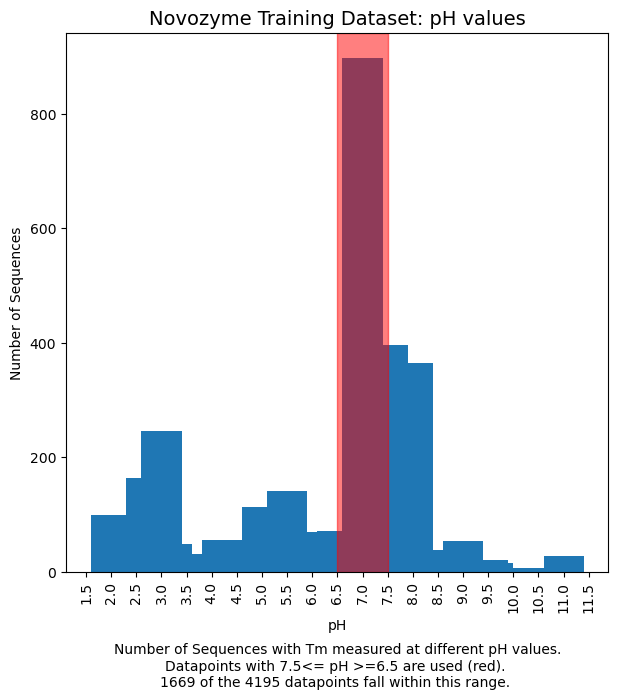

(4195, 8)
   seq_id                                   protein_sequence   pH  \
0   18023  MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  6.5   
1   18061  MNCFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  6.5   
2   18062  MNCFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  6.5   
3   18072  MNDFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  6.5   
4   18113  MNEFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  6.5   

        data_source    tm    x  group  \
0  10.1038/334406a0  62.9  164      0   
1               NaN  65.0  164      0   
2               NaN  64.7  164      0   
3  10.1038/334406a0  56.2  164      0   
4  10.1038/334406a0  59.0  164      0   

                                            wildtype  
0  MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  
1  MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  
2  MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  
3  MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  
4  MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL... 

<Figure size 640x480 with 0 Axes>

In [110]:
# read csv
import pandas as pd
#This is the updates training set of Novozyme taken from: https://www.kaggle.com/competitions/novozymes-enzyme-stability-prediction/discussion/356251
wt_group_df=pd.read_csv("/home/lilian/TCR_Graphs/Novozyme_data/AF_WT/train_wildtype_groups.csv")
#count how many rows have same value for ph
df=wt_group_df["pH"].value_counts()
print(df)
print(min(df.index))
print(max(df.index))
#make graph of pH values
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(7,7))
plt.tight_layout()
plt.bar(df.index,df.values)
plt.xlabel("pH")
plt.ylabel("Number of Sequences")
plt.title("Novozyme Training Dataset: pH values", fontsize=14)
plt.xticks(np.arange(1.5, 12, 0.5))
plt.xticks(rotation=90)
#higlight pH 6.5 to pH 7.5 in red
plt.axvspan(6.5, 7.5, color='red', alpha=0.5)
txt="""Number of Sequences with Tm measured at different pH values.
Datapoints with 7.5<= pH >=6.5 are used (red). 
1669 of the 4195 datapoints fall within this range. """
plt.text(6.5, -200, txt, fontsize=10, ha="center")
plt.show()
plt.savefig("/home/lilian/TCR_Graphs/docs/graphs/ph_values_Novozyme_train.png",dpi=300)

print(wt_group_df.shape)

#keep only rows with ph=7
#wt_group_df=wt_group_df[wt_group_df["pH"]==7]
wt_group_df=wt_group_df[wt_group_df["pH"]>=6.5]
wt_group_df=wt_group_df[wt_group_df["pH"]<=7.5]

#index reset
wt_group_df=wt_group_df.reset_index(drop=True)
print(wt_group_df.head())
#write to file
wt_group_df.to_csv("/home/lilian/TCR_Graphs/Novozyme_data/AF_WT/train_wildtype_groups_ph_6.5_7.5.csv", header=True, index=True)

897 sequences with Tm at pH7. These will be encoded and a model is trained on predicting Tm. 

run esm_encoder to generate csv file

In [135]:
#read csv to df
import pandas as pd
import numpy as np
import torch
import ast
#tensor of length 1280 per sequence
esm_df=pd.read_csv("/home/lilian/TCR_Graphs/Novozyme_data/AF_WT/seq_representations_ph6575.csv",sep=";", header=None) 
esm_df.columns = ["id", "tm","esm"] 
for i in esm_df.index:
    esm_df["esm"][i]=np.array(ast.literal_eval(esm_df["esm"][i]))
print(esm_df.head())  

/tmp/ipykernel_1102072/4273780204.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



      id    tm                                                esm
0  18023  62.9  [0.08105135709047318, -0.14088843762874603, -0...
1  18061  65.0  [0.07946237921714783, -0.14203152060508728, -0...
2  18062  64.7  [0.07946237921714783, -0.14203152060508728, -0...
3  18072  56.2  [0.08699294179677963, -0.13731181621551514, -0...
4  18113  59.0  [0.08887691050767899, -0.1366855800151825, -0....


In [136]:
#transform esm dataframes to one dataframe with 1280 columns for PCA analysis
new_esm_df=pd.DataFrame(columns=[str(i) for i in range(1,len(esm_df["esm"][i])+1)]+["id", "tm"])
for i in esm_df.index:
    array_esm=list(esm_df["esm"][i])+[esm_df["id"][i],esm_df["tm"][i]]
    for a in range(len(array_esm)):
        new_esm_df.loc[i] = array_esm
print(new_esm_df.head())
print(new_esm_df.shape)


          1         2         3         4         5         6         7  \
0  0.081051 -0.140888 -0.024027  0.073594 -0.177288  0.012133  0.071402   
1  0.079462 -0.142032 -0.023219  0.074079 -0.179208  0.015475  0.069047   
2  0.079462 -0.142032 -0.023219  0.074079 -0.179208  0.015475  0.069047   
3  0.086993 -0.137312 -0.020412  0.071302 -0.174607  0.011103  0.066139   
4  0.088877 -0.136686 -0.019851  0.071763 -0.175287  0.010922  0.065147   

          8         9        10  ...      1273      1274      1275      1276  \
0 -0.210401 -0.118104  0.062028  ... -0.110395  0.079891  0.046398  0.103387   
1 -0.208284 -0.117104  0.064740  ... -0.109563  0.078257  0.046352  0.105464   
2 -0.208284 -0.117104  0.064740  ... -0.109563  0.078257  0.046352  0.105464   
3 -0.208098 -0.114807  0.055610  ... -0.106136  0.076631  0.046376  0.107498   
4 -0.210134 -0.113660  0.056955  ... -0.107356  0.075317  0.046189  0.105423   

       1277      1278      1279      1280       id    tm  
0  0.0191

In [139]:
!pip install -U kaleido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 29.3 MB/s eta 0:00:0000:0100:01


In [140]:
import plotly.express as px
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
components = pca.fit_transform(new_esm_df[[str(i) for i in range(1,len(esm_df["esm"][i])+1)]])
pca_df=pd.DataFrame(components, columns=["PCA1","PCA2"])
#merge pca_df with esm_df
pca_df=pd.concat([pca_df,esm_df[["id", "tm"]]],axis=1)
print(pca_df.head())

fig = px.scatter(pca_df, x="PCA1", y="PCA2", color="tm",title="PCA of Novozyme ESM encoding")


#description:
"""PCA of Novozyme Training data sequences with Tm measured at pH >=6.5, <=7.5. Sequences were encoded with ESM2 and principal components one and two were plotted.
The data points are colored according to the Tm value of sequences."""
fig.show()
fig.write_image("/home/lilian/TCR_Graphs/docs/graphs/PCA_Novozyme_train_ph_6.5_7.5.png")



       PCA1      PCA2     id    tm
0  3.118627  1.721113  18023  62.9
1  3.072117  1.714718  18061  65.0
2  3.072117  1.714718  18062  64.7
3  3.027825  1.699021  18072  56.2
4  3.026874  1.692608  18113  59.0


ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


In [56]:
import pandas as pd
af2_df=pd.read_csv("/home/lilian/TCR_Graphs/Novozyme_data/AF_WT/alpha_fold_df.csv")
af2_df["protein_sequence"]=af2_df["af2_sequence"]
comb_df=pd.merge(af2_df, wt_group_df, on='protein_sequence')
comb_df.columns
comb_df=comb_df[['af2id', 'cif', 'confidence', 'err','protein_sequence', 'pH', 'tm', 'group']]
print(comb_df.shape)
#print rows where tm is not nan
comb_df=comb_df[comb_df["tm"].notna()]
print(comb_df.shape)
print(comb_df.head(15))



(47, 8)
(47, 8)
                    af2id                                                cif  \
0   AFDB:AF-A0A7M1TZM4-F1  gs://public-datasets-deepmind-alphafold/AF-A0A...   
1   AFDB:AF-A0A0D8BY14-F1  gs://public-datasets-deepmind-alphafold/AF-A0A...   
2   AFDB:AF-A0A178TVQ4-F1  gs://public-datasets-deepmind-alphafold/AF-A0A...   
3   AFDB:AF-A0A1Q5SY33-F1  gs://public-datasets-deepmind-alphafold/AF-A0A...   
4   AFDB:AF-A0A854GXQ0-F1  gs://public-datasets-deepmind-alphafold/AF-A0A...   
5       AFDB:AF-S7TZT3-F1  gs://public-datasets-deepmind-alphafold/AF-S7T...   
6   AFDB:AF-A0A150M3I2-F1  gs://public-datasets-deepmind-alphafold/AF-A0A...   
7   AFDB:AF-A0A142CZQ5-F1  gs://public-datasets-deepmind-alphafold/AF-A0A...   
8       AFDB:AF-L7ZXE1-F1  gs://public-datasets-deepmind-alphafold/AF-L7Z...   
9   AFDB:AF-A0A4D7Q9I3-F1  gs://public-datasets-deepmind-alphafold/AF-A0A...   
10  AFDB:AF-A0A150MHX6-F1  gs://public-datasets-deepmind-alphafold/AF-A0A...   
11  AFDB:AF-A0A6N3WNW0-F

In [59]:
print(wt_group_df.wildtype.unique().shape)
#print(af2_df.wildtype.unique().shape)
#print(comb_df.wildtype.unique().shape) 


(47,)


In [41]:
print(af2_df.columns)
print(af2_df.af2_sequence.unique().tolist())
print(wt_group_df.wildtype.unique().tolist())
print(wt_group_df.protein_sequence.unique().tolist())
print(len(af2_df.af2_sequence.unique().tolist()), len(wt_group_df.wildtype.unique().tolist()), len(wt_group_df.protein_sequence.unique().tolist()))
#check how many sequences are in both lists
print(len(set(af2_df.af2_sequence.unique().tolist()) & set(wt_group_df.wildtype.unique().tolist())))
print(len(set(af2_df.af2_sequence.unique().tolist()) & set(wt_group_df.protein_sequence.unique().tolist())))
print(len(wt_group_df.wildtype.tolist()))

Index(['af2id', 'metadata', 'af2_sequence', 'cif', 'confidence', 'err'], dtype='object')
['MISLIAALAVDRVIGMENAMPWNLPADLAWFKRNTLNKPVIMGRHTWESIGRPLPGRKNIILSSQPGTDDRVTWVKSVDEAIAACGDVPEIMVIGGGRVYEQFLPKAQKLYLTHIDAEVEGDTHFPDYEPDDWESVFSEFHDADAQNSHSYCFEILERR', 'MKFVKRRIIALVTILMLSVTSLFALQPSAKAAEHNPVVMVHGIGGASFNFAGIKSYLVSQGWSRDKLYAVDFWDKTGTNYNNGPVLSRFVQKVLDETGAKKVDIVAHSMGGANTLYYIKNLDGGNKVANVVTLGGANRLTTGKALPGTDPNQKILYTSIYSSADMIVMNYLSRLDGARNVQIHGVGHIGLLYSSQVNSLIKEGLNGGGQNTN', 'MQRGKVKWFNNEKGYGFIEVEGGSDVFVHFTAIQGEGFKTLEEGQEVSFEIVQGNRGPQAANVVKL', 'MTKQEKTALNMARFIRSQTLTLLEKLNELDADEQADICESLHDHADELYRSCLARFGDDGENL', 'MLPKLVITHRVHDEILQLLAPHCELMTNQTDSTLTREEILRRCRDAQAMMAFMPDRVDADFLQACPELRVVGCALKGFDNFDVDACTARGVWLTFVPDLLTVPTAELAIGLAVGLGRHLRAADAFVRSGEFQGWQPQFYGTGLDNATVGILGMGAIGLAMADRLQGWGATLQYHEAKALDTQTEQRLGLRQVACSELFASSDFILLALPLNADTQHLVNAELLALVRPGALLVNPCRGSVVDEAAVLAALERGQLGGYAADVFEMEDWARADRPRLIDPALLAHPNTLFTPHIGSAVRAVRLEIERCAAQNIIQVLAGARPINAANRLPKAEPAAC', 'MSSRKELANAIRALSMDAVQKAKSGHPGAPMGMADIAEVLWRDFLKHNPQNPS

In [ ]:
I have 897 datapoints of mutated sequences with Tm, that have a corresponding wildtype structure  (at pH7)